In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot convergence for IMEX-RB on 2D nonlinear problem
We study convergence on the 2D viscous Burgers equation

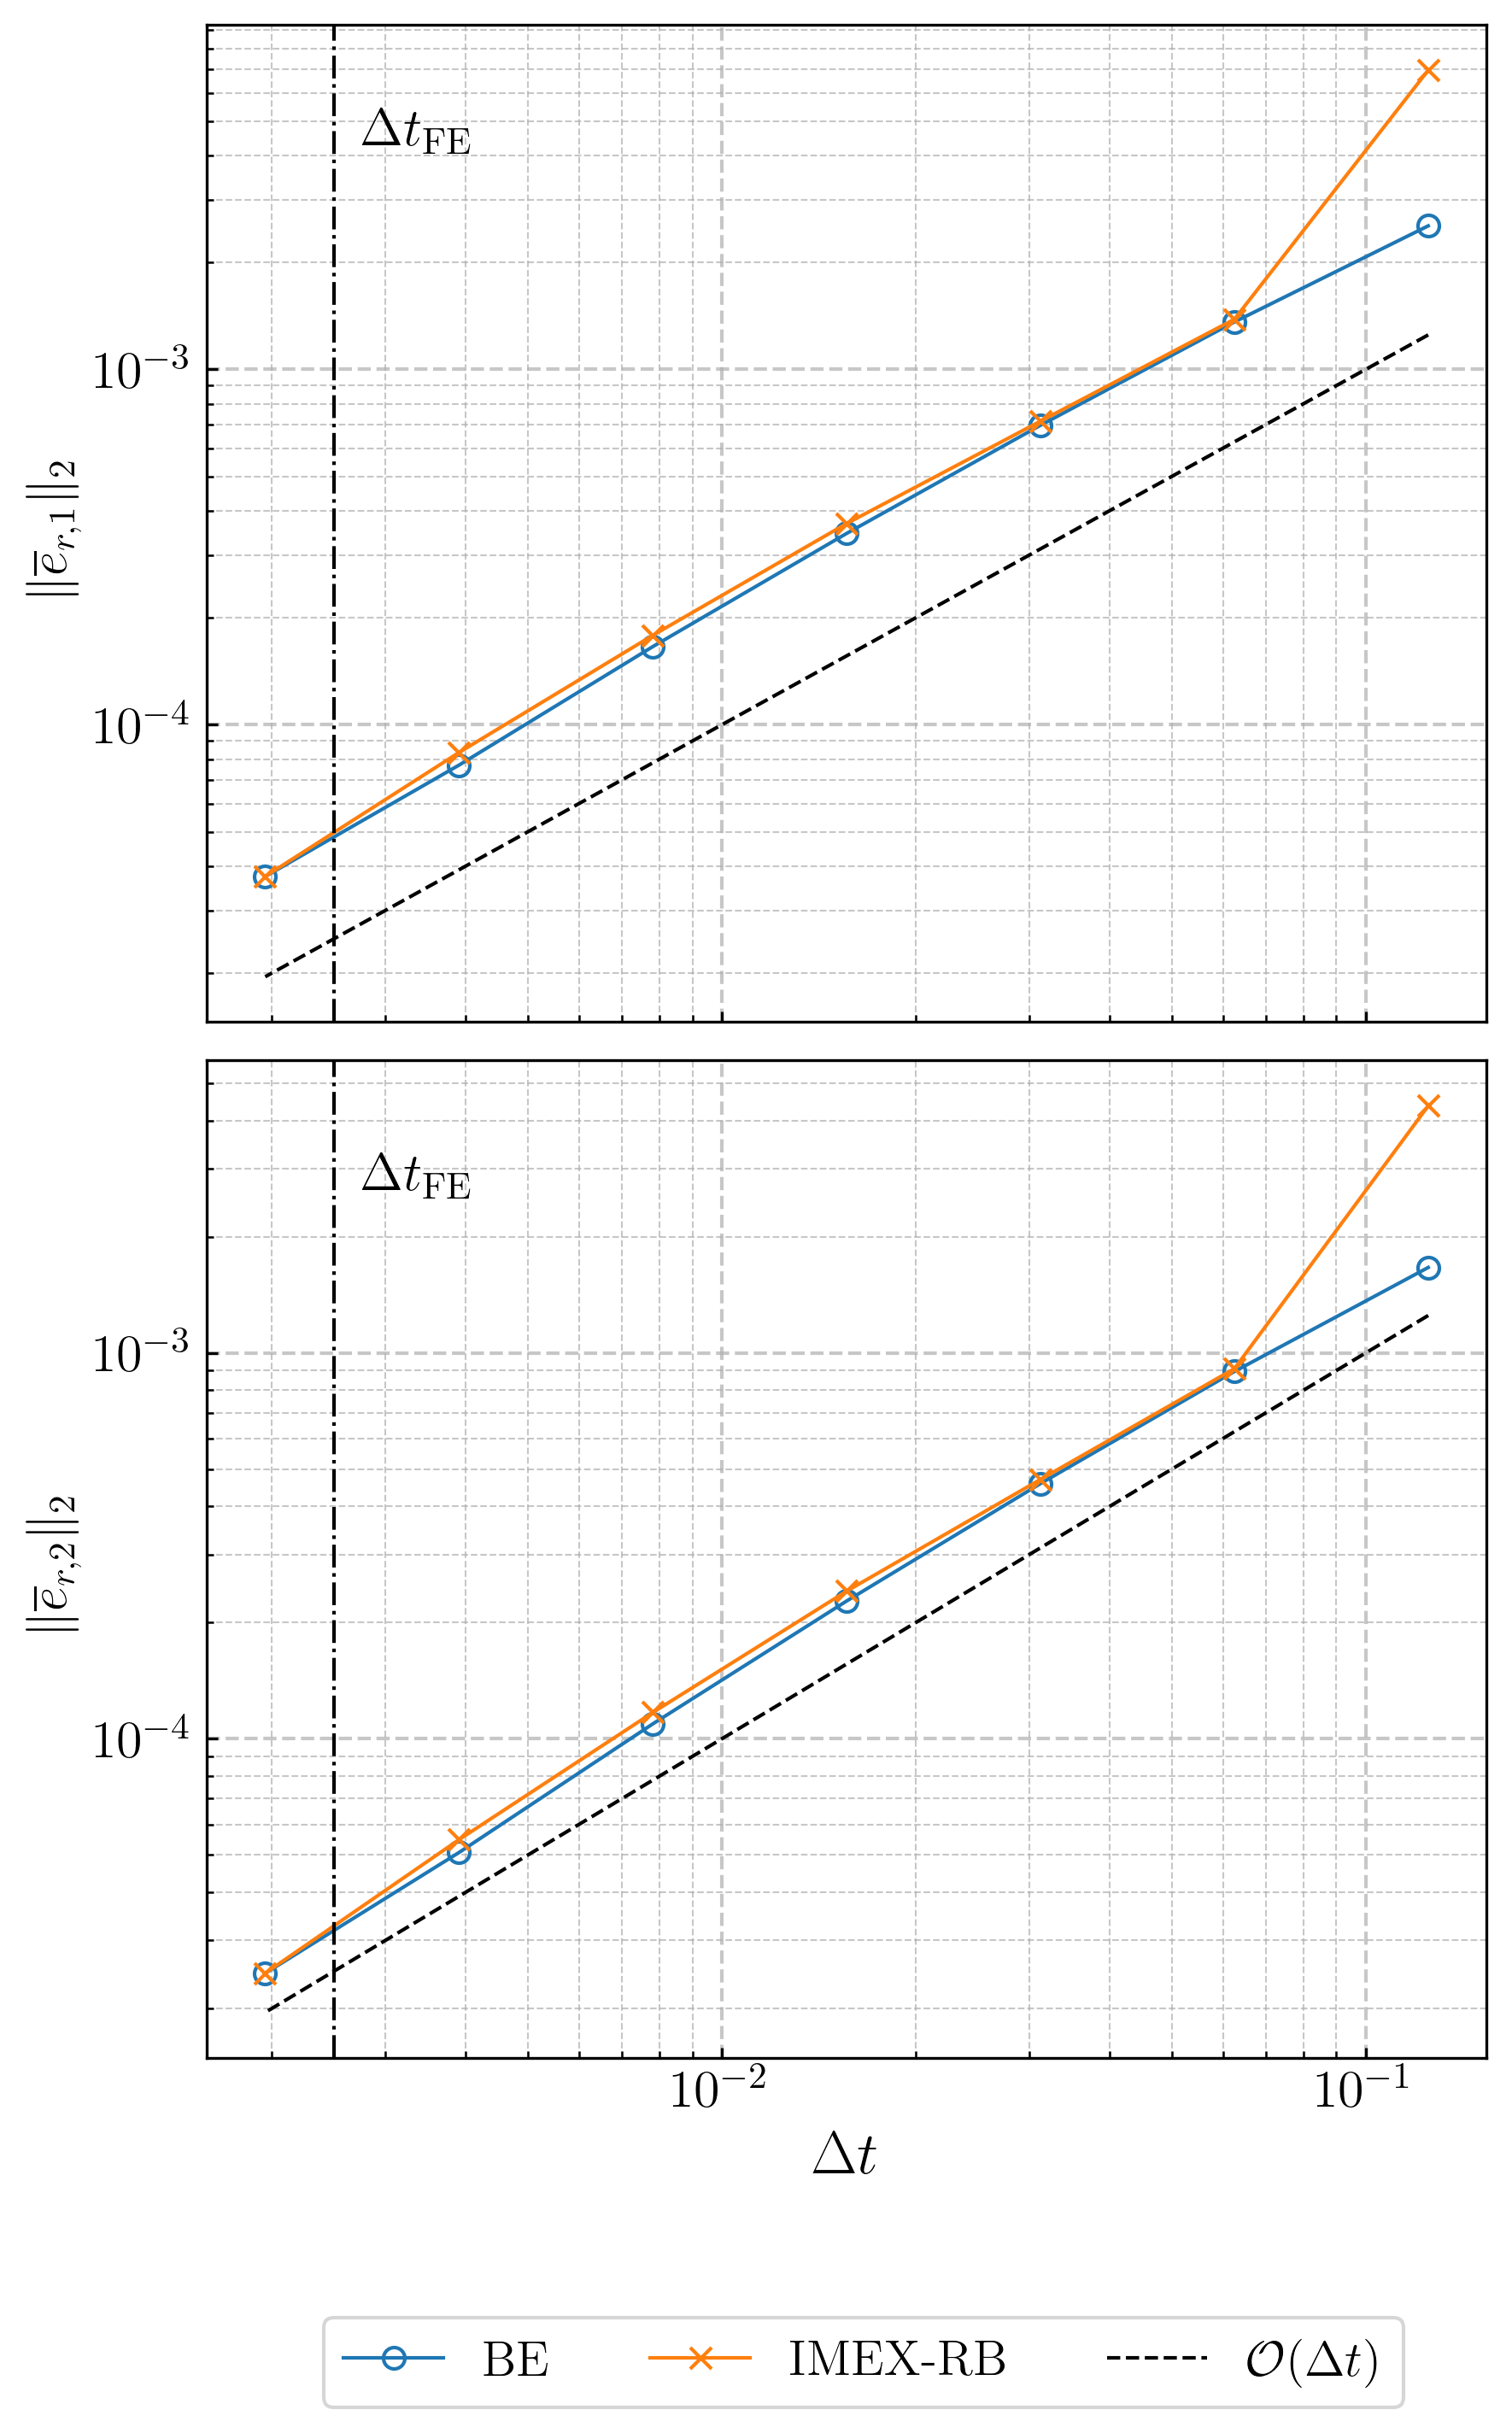

In [6]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = "Burgers2D"
test_name = "convergence"
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_l2 = data['errors_l2'].item()
Nt_values = data['Nt_values']

dts = 1.0 / np.array(Nt_values)
methods = ['BE', 'IMEX-RB']
markers_list = ['o', 'x']
fill_list = ['none', 'full']

fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

for comp in range(errors_l2[methods[0]].shape[0]):
    ax = axes[comp]
    for m_idx, m in enumerate(methods):
        errs = errors_l2[m][comp]
        ax.loglog(
            dts,
            errs,
            marker=markers_list[m_idx],
            fillstyle=fill_list[m_idx],
            markersize=6,
            linestyle='-',
            label=m
        )
    ax.loglog(
        dts,
        [dt / 100.0 for dt in dts],
        label=r"$\mathcal{O}(\Delta t)$",
        color="k",
        linestyle='--'
    )
    ax.axvline(1 / 400, color="k", linestyle='-.')
    ax.text(
        1 / 400 * 1.1,
        ax.get_ylim()[1] * 0.5,
        rf'$\Delta t_{{\mathrm{{FE}}}}$',
        rotation=0,
        verticalalignment='center',
        color='k',
        fontsize=15
    )
    ax.grid(which='major', linestyle='--', linewidth=1)
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if comp == 1:
        ax.set_xlabel(r'$\Delta t$', fontsize=17)
    ax.set_ylabel(rf'$\|\overline{{e}}_{{r,{comp+1}}}\|_2$', fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.57, -0.0),
    loc='upper center',
    ncol=3,
    fontsize=14
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
out_file = os.path.join(plots_dir, f'{problem_name}_convergence_combined.pdf')
plt.savefig(out_file, bbox_inches='tight', dpi=400)
plt.show()
plt.close()
